# Seminar Project: Subsetting Speeches
---------------
``` 

Jakob Amann
Elias Gabriel Heppner, 1244414
Andri Rutschmann

### Loading Packages


In [1]:
import numpy as np 
import pandas as pd 
import time
import pickle
import time
import os
import datetime
import zipfile
# from t    qdm.auto import tqdm
from tqdm import tqdm # use this import for better kaggle compatibility
from collections import defaultdict 
import re
import matplotlib.pyplot as plt
import math
import json

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline


C:\Users\Jakob\AppData\Local\Temp\ipykernel_7856\4123590331.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jakob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\Jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Speeches Data


In [4]:
# # For kaggle, just reload .pkl and .jsons

# # file_path = '/kaggle/input/sub-speeches-data-input/sub_speeches.pkl'
# file_path = '/kaggle/input/preprocessed-speeches/parliament_speeches.pkl' # for preprocseed speeches
# df = pd.read_pickle(file_path)
# print(df.isna().any())
# df.head()


# file_path_llm_par = '/kaggle/input/gpt-outputs-politricks/gpt_output/llm_speeches_party.json' 
# with open(file_path_llm_par, 'r') as file:
#     llm_speeches_party = json.load(file)


# file_path_llm_pol = '/kaggle/input/gpt-outputs-politricks/gpt_output/llm_speeches_pol.json'
# with open(file_path_llm_pol, 'r') as file:
#     llm_speeches_pol = json.load(file)

# file_path_llm_pol_par = '/kaggle/input/gpt-outputs-politricks/gpt_output/llm_speeches_pol_party.json'
# with open(file_path_llm_pol_par, 'r') as file:
#     llm_speeches_pol_party = json.load(file)

In [8]:
# # For Local Use
# print(os.getcwd())
# os.chdir("../data")

# # zip_file_path = "sub_speeches.zip"
# zip_file_path = r"sub_speeches.pkl.zip" # changed it to pickle file as .csv introduced NA values

# # Name of the CSV file inside the zip file
# # csv_filename = "sub_speeches.csv"
# pkl_filename = r"sub_speeches.pkl"

# # Open the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Check if the CSV file exists in the zip file
#     if pkl_filename in zip_ref.namelist():
#         # Extract the CSV file
#         with zip_ref.open(pkl_filename) as csv_file:
#             # Read the CSV file using pandas
#             # df = pd.read_csv(csv_file)
#             df = pd.read_pickle(csv_file)

#             print(df.head())  # Display the first few rows of the dataframe
#     else:
#         print(f"{pkl_filename} not found in the zip file.")

# df.isna().any()



os.chdir("../data/kaggle_outputs")
# reload covid, migration and ukraine_war speeches from .pkl files
covid_speeches = pd.read_pickle('covid_speeches_manifestoberta.pkl')
migration_speeches = pd.read_pickle('migration_speeches_manifestoberta.pkl')
ukraine_war_speeches = pd.read_pickle('ukraine_war_speeches_manifestoberta.pkl')


# reload jsons with manifestoberta outputs
file_path_llm_par = r'llm_speeches_party_manifestoberta.json' 
with open(file_path_llm_par, 'r', encoding='utf-8') as file:
    llm_speeches_party = json.load(file)

file_path_llm_pol = r'llm_speeches_pol_manifestoberta.json'
with open(file_path_llm_pol, 'r', encoding='utf-8') as file:
    llm_speeches_pol = json.load(file)

file_path_llm_pol_par = r'llm_speeches_pol_party_manifestoberta.json'
with open(file_path_llm_pol_par, 'r', encoding='utf-8') as file:
    llm_speeches_pol_party = json.load(file)

## Topic-Selection for Speeches using RegEx 

This was already done and can be skipped as we already reloaded the already preprocessed files earlier. 

In [21]:
# # we need to look at speech_content
#     # Let's start with Ukraine War
# fin_df = df.copy()

# # regex pattern to match speeches about the war on Ukraine
# pattern_ukraine_war = r'(?i)\b(Krieg|Konflikt|Invasion|Krise|Angriffskrieg|conflict|crisis)\b.*\b(Ukraine|Kyiv|Donbas|Krim|Kiew|Russland|Putin|Moskau)\b|\b(Ukraine|Kyiv|Donbas|Krim|Kiew|Russland|Putin|Moskau)\b.'
# matches_ukraine_war = fin_df['speech_content'].str.contains(pattern_ukraine_war, case=False, flags=re.IGNORECASE)
# ukraine_war_speeches = fin_df[matches_ukraine_war]
# print(len(ukraine_war_speeches))


# # now Covid
# pattern_covid = r'(?i)\b(COVID-19|Coronavirus|Pandemie|SARS-CoV-2|Quarantäne|Lockdown|Social Distancing|Ausgangsbeschränkung(en)?|Maskenpflicht|Impfpass|Corona-Virus|Infektion(en)?|Gesundheitsnotstand|Impfpflicht)\b'
# matches_covid = fin_df['speech_content'].str.contains(pattern_covid, case=False, flags=re.IGNORECASE)
# covid_speeches = fin_df[matches_covid]
# print(len(covid_speeches))

# # now Migration 
# pattern_migration = r'(?i)\b(Flüchtlinge?|Migration|Asylbewerber?|Geflüchtete?|Asylverfahren|Einwanderer?|Auswanderer?|Immigrant(en)?|Emigrant(en)?|Zuwanderer?|Vertriebene?|Schutzsuchende?|Migranten?|Asylrecht|Grenzübergang|Visapolitik|Einreiseverbot)\b'
# matches_migration = fin_df['speech_content'].str.contains(pattern_migration, case=False, flags=re.IGNORECASE)
# migration_speeches = fin_df[matches_migration]
# print(len(migration_speeches))

# Topic Modelling using Parlbert-Topic-German

In [3]:
def classify_speeches(speeches, pipeline_classification_topics, max_length=250):
    """
    Classify a list of speeches into topics using batching.
    
    :param speeches: List of speech texts.
    :param pipeline_classification_topics: The classification pipeline.
    :param max_length: Maximum token length for each chunk.
    :return: List of most common topics for each speech.
    """
    batched_topics = []
    start_time = time.time()
    for speech in speeches:
        tokens = word_tokenize(speech, language='german')
        # Split speech into chunks
        token_chunks = [' '.join(tokens[i:i + max_length]) for i in range(0, len(tokens), max_length)]
        if not token_chunks:  # Handle case where speech might be empty or very short
            batched_topics.append(None)
            continue

        # Process all chunks at once using the pipeline
        topics_in_speech = pipeline_classification_topics(token_chunks)
        # Find the most common topic in the speech
        topics = [topic['label'] for topic in topics_in_speech]
        most_common_topic = max(set(topics), key=topics.count)
        batched_topics.append(most_common_topic)
    end_time = time.time()
#     print(f'For {len(speeches)} speeches, it took {end_time-start_time} seconds')
    return batched_topics


In [ ]:
### Execution of Topic Modelling
# implemented for complete df, then for ukraine_war-, covid-, migration-speeches

# batch_size = 10  # adjust batch size
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# pipeline_classification_topics = pipeline("text-classification", model="chkla/parlbert-topic-german", return_all_scores=False, device=device, truncation=False)

# results = []
# for start in tqdm(range(0, len(df), batch_size)):
#     end = start + batch_size
#     speeches_batch = df['speech_content'][start:end]#.tolist()
#     batch_results = classify_speeches(speeches_batch, pipeline_classification_topics)
#     results.extend(batch_results)
#     if start %3000==0: # every 3000th row, we make a safety copy
#          with open(f'results_lists/results_topic_label_last_row_{end}.pkl', 'wb') as f:
#                 pickle.dump(results, f)

# # Add results to DataFrame
# df['topic_label'] = results
# # df['topic_label'] = tqdm(df['speech_content'].apply(get_topic_from_speech)) # old approach, no loop necessary, no batching


# output_dir = "/kaggle/working/kaggle_outputs_final"
# os.makedirs(output_dir, exist_ok=True)
# output_file_path = os.path.join(output_dir, "parliament_speeches_with_topics.pkl")
# df.to_pickle(output_file_path)



  0%|          | 68/36053 [1:46:37<634:25:32, 63.47s/it]  

# Groundtruthing using Manifestoberta


Let's go with the sentence model as the context model adds just a mere 7% accuracy and is way more complex to implement. I think, we'd have to use each sentence + it's previous/following sentence as context.

The sentence model should be used for sentences, but let's check if there are any restrictions and/or problems arising, when we give multiple sentences.

In [24]:
model = AutoModelForSequenceClassification.from_pretrained("manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1") # https://huggingface.co/manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    model = model.cuda()

def get_average_dimension_values(speech_in_sentences):
    '''
    input: 
    speech_in_sentences: a whole speech/article as list of strings/sentences. Each single object should have at max 200 tokens to be usable for the model 

    output:
    dimension_values_dict: dict with all dimensions, sorted by the highest values with manifesto_dimensions as keys
    '''
    sum_probabilities = defaultdict(float)  # this makes sure we have just 0.0 if the key was not found
    for sentence in speech_in_sentences:
        inputs = tokenizer(sentence,
                           return_tensors="pt",
                           max_length=200,  # we limited the input to 200 tokens during finetuning
                           padding="max_length",
                           truncation=True
                           ).to(device)

        with torch.no_grad():  # Inference mode, no gradients needed
            logits = model(**inputs).logits
        probabilities = torch.softmax(logits, dim=1).cpu().tolist()[0]
        probabilities = {model.config.id2label[index]: round(probability * 100, 2) for index, probability in enumerate(probabilities)}
        for dimension, probability in probabilities.items():
            sum_probabilities[dimension] += probability

    # calculate average probabilities for each dimension
    avg_probabilities = {dimension: round(total / len(speech_in_sentences), 2) for dimension, total in sum_probabilities.items()}
    avg_probabilities_sorted = dict(sorted(avg_probabilities.items(), key=lambda item: item[1], reverse=True))
    return avg_probabilities_sorted


## Groundtruhting Real Speeches

In [23]:
# model = AutoModelForSequenceClassification.from_pretrained("manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1")
# tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# if torch.cuda.is_available():
#     model = model.cuda()

# # Manifestoberta for ukraine_war, covid and migration speeches (original speeches)
# result_dict_list = [] 
# for speech in tqdm(ukraine_war_speeches['speech_content'], miniters = 1): # first two speeches already take around 2.45 min
#     speech_in_sentences = nltk.tokenize.sent_tokenize(speech)
#     result_dict = get_average_dimension_values(speech_in_sentences)
#     result_dict_list.append(result_dict)
# with open(f'results_lists/all_results_ukraine_war.pkl', 'wb') as f:
#                 pickle.dump(result_dict_list, f)
# results_df = pd.DataFrame(result_dict_list)
# ukraine_war_speeches = pd.concat([ukraine_war_speeches.reset_index(drop=True), results_df], axis=1)
# ukraine_war_speeches.to_pickle('ukraine_war_speeches_manifestoberta.pkl')

# result_dict_list = [] 
# for speech in tqdm(migration_speeches['speech_content'], miniters = 1): # first two speeches already take around 2.45 min
#     speech_in_sentences = nltk.tokenize.sent_tokenize(speech)
#     result_dict = get_average_dimension_values(speech_in_sentences)
#     result_dict_list.append(result_dict)
# with open(f'results_lists/all_results_migration.pkl', 'wb') as f:
#                 pickle.dump(result_dict_list, f)
# results_df = pd.DataFrame(result_dict_list)
# migration_speeches = pd.concat([migration_speeches.reset_index(drop=True), results_df], axis=1)
# migration_speeches.to_pickle('migration_speeches_manifestoberta.pkl')

# result_dict_list = [] 
# for speech in tqdm(covid_speeches['speech_content'], miniters = 1): # first two speeches already take around 2.45 min
#     speech_in_sentences = nltk.tokenize.sent_tokenize(speech)
#     result_dict = get_average_dimension_values(speech_in_sentences)
#     result_dict_list.append(result_dict)
# with open(f'results_lists/all_results_covid.pkl', 'wb') as f:
#             pickle.dump(result_dict_list, f)
# results_df = pd.DataFrame(result_dict_list)
# covid_speeches = pd.concat([covid_speeches.reset_index(drop=True), results_df], axis=1)
# covid_speeches.to_pickle('covid_speeches_manifestoberta.pkl')


## Groundtruthing Artificial Speeches

In [70]:
# gpt_outputs = [llm_speeches_party, llm_speeches_pol, llm_speeches_pol_party]
# gpt_outputs_names = ['llm_speeches_party', 'llm_speeches_pol', 'llm_speeches_pol_party']

# topics = ['Ukraine-Krieg', 'Covid-19', 'Migration']
# counter = 0

# for index, (output, output_name) in enumerate(zip(gpt_outputs, gpt_outputs_names)):
#     modified_output_data = [] # this holds the modified output data, which be added to a list and stored
#     for pol_party_output in output: # we iterate over each party/pol
#         if 'manifestoberta_output' not in pol_party_output:
#             pol_party_output['manifestoberta_output'] = {}
#         for topic in topics: 
#             individual_speeches = pol_party_output['llm_output'][topic]
#             manifestoberta_outputs_list = []
#             for speech in individual_speeches: 
#                 counter += 1
#                 cleaned_speech = re.sub('(?=\[).*(?!\])', '', speech)
#                 cleaned_speech_in_sentences = nltk.tokenize.sent_tokenize(cleaned_speech)
#                 manifestoberta_output = get_average_dimension_values(cleaned_speech_in_sentences)
#                 manifestoberta_outputs_list.append(manifestoberta_output)

#             pol_party_output['manifestoberta_output'][topic] = manifestoberta_outputs_list # this line needs to be changed
#         modified_output_data.append(pol_party_output) # here, we make sure we get back the same structure as the input but with the added column

#     filename = f"{output_name}_manifestoberta.json"
#     file_path = os.path.join("/kaggle/working/", filename)

#     os.makedirs(os.path.dirname(file_path), exist_ok=True)

#     with open(file_path, 'w', encoding='utf-8') as f:
#         json.dump(modified_output_data, f, ensure_ascii=False, indent=4)

#     print(f"Saved: {file_path}")

# Exploration & Evaluation 

In [72]:
# Take care of varying ways to write DIE LINKE
ukraine_war_speeches['abbreviation'] = ukraine_war_speeches['abbreviation'].replace('DIE LINKE.', 'DIE LINKE')
covid_speeches['abbreviation'] = covid_speeches['abbreviation'].replace('DIE LINKE.', 'DIE LINKE')
migration_speeches['abbreviation'] = migration_speeches['abbreviation'].replace('DIE LINKE.', 'DIE LINKE')



### Visualisations
Let's make some example visualisations using the axis, military: Positive/Negative and European Community/Union: Positive/Negative. 


In [29]:
## Used data 
# covid_speeches 
# migration_speeches 
# ukraine_war_speeches 
# llm_speeches_pol 
# llm_speeches_pol_party 
# llm_speeches_party 

In [109]:
party_colors = {
    'CDU/CSU': 'blue',
    'SPD': 'red',
    'AfD': 'cyan',
    'FDP': 'yellow',
    'DIE LINKE': 'purple',
    'Grüne': 'green',
}

def plot_dimension_comparison(llm_speeches, df_speeches, topic_of_interest, dims_x, dims_y, party_colors = party_colors):
    '''
    input: 
    - llm_speeches = list of dicts (from .json)
    - df_speeches = one of the 3 topic dfs (covid_speeches, migration_speeches, war_on_ukraine_speeches)
    - topic_of_interest = 'Ukraine-Krieg', 'Covid-19', 'Migration'
    - dims_x, dims_y = list of dimensions from manifestoberta, important to use list as we can deal with 1 as well as 2 dimensions per axis, 2 dimensions will be substracted (first - second)

    output: 
    - nice plot showing the position and the party association
    '''
    party_names = [d['party'] for d in llm_speeches]

    def calculate_value(d, dimensions, topic):
        speeches = d['manifestoberta_output'][topic]
        
        if len(dimensions) == 1: # if we only deal with 1 dimension (e.g., Military Positive only)
            total = sum(speech[dimensions[0]] for speech in speeches)
            average = total / len(speeches)
            return average
        elif len(dimensions) == 2: # if we deal with 2 dimensions (e.g., Military Positive - Military Negative)
            total_dim1 = sum(speech[dimensions[0]] for speech in speeches)
            average_dim1 = total_dim1 / len(speeches)
            total_dim2 = sum(speech[dimensions[1]] for speech in speeches)
            average_dim2 = total_dim2 / len(speeches)
            
            difference = average_dim1 - average_dim2
            return difference
    
    x_values = [calculate_value(d, dims_x, topic_of_interest) for d in llm_speeches]
    y_values = [calculate_value(d, dims_y, topic_of_interest) for d in llm_speeches]

    plt.figure(figsize=(10, 10))

    # plot LLM data points
    for x, y, party in zip(x_values, y_values, party_names):
        plt.scatter(x, y, color=party_colors.get(party, 'black'), label=f"{party} (Artificial)")

    # plot Bundestag df data points
    for party in party_colors.keys():
        df_filtered = df_speeches[df_speeches['abbreviation'] == party]
        if not df_filtered.empty:
            avg_x = calculate_value({'manifestoberta_output': {topic_of_interest: df_filtered.to_dict('records')}}, dims_x, topic_of_interest)
            avg_y = calculate_value({'manifestoberta_output': {topic_of_interest: df_filtered.to_dict('records')}}, dims_y, topic_of_interest)
            plt.scatter(avg_x, avg_y, color=party_colors[party], edgecolor='k', marker='d', s=100, label=f"{party} (Real)")

    plt.xlabel(' - '.join(dims_x)) # we join on a minus as we substract the values if we have multiple dimensions
    plt.ylabel(' - '.join(dims_y))
    plt.title(f'{topic_of_interest}: Comparison of LLM-Generated Speeches and Party Values of Real Bundestag Speeches')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.subplots_adjust(right=0.75)
    plt.show()


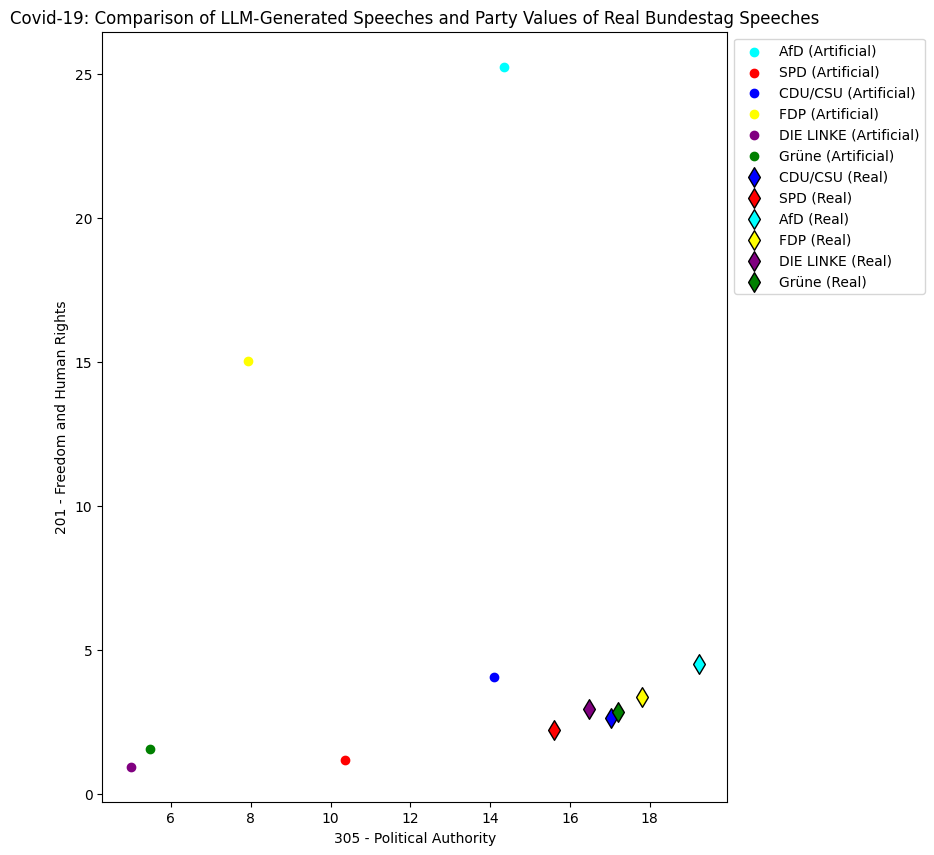

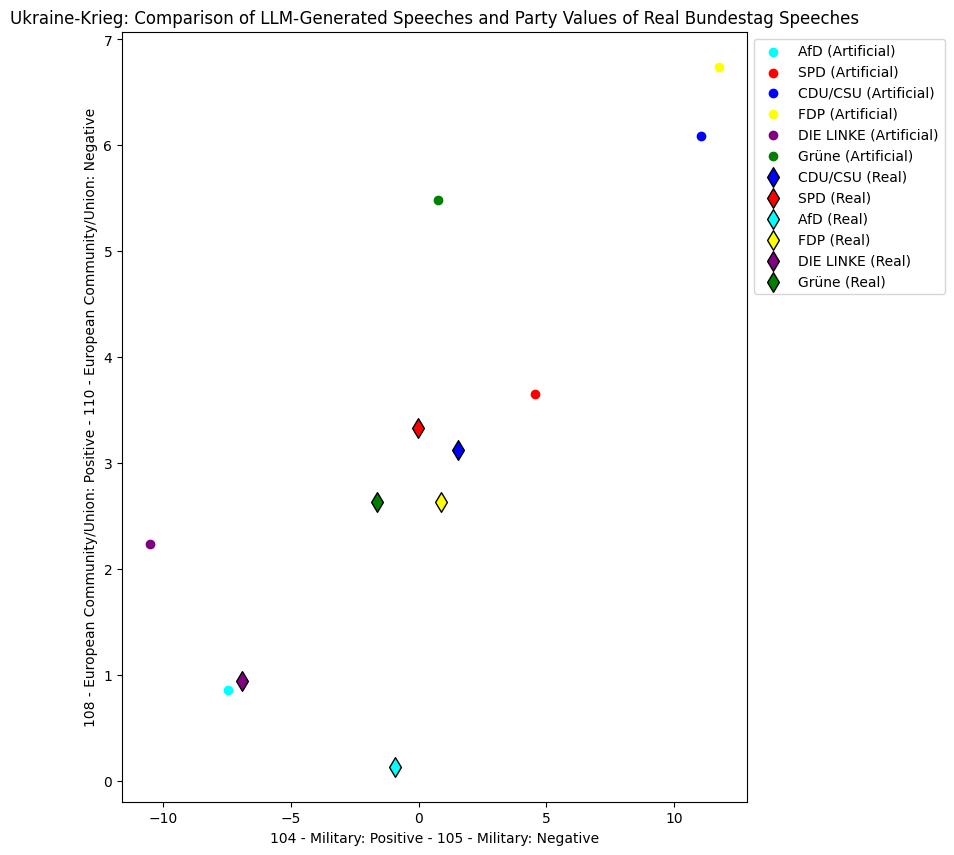

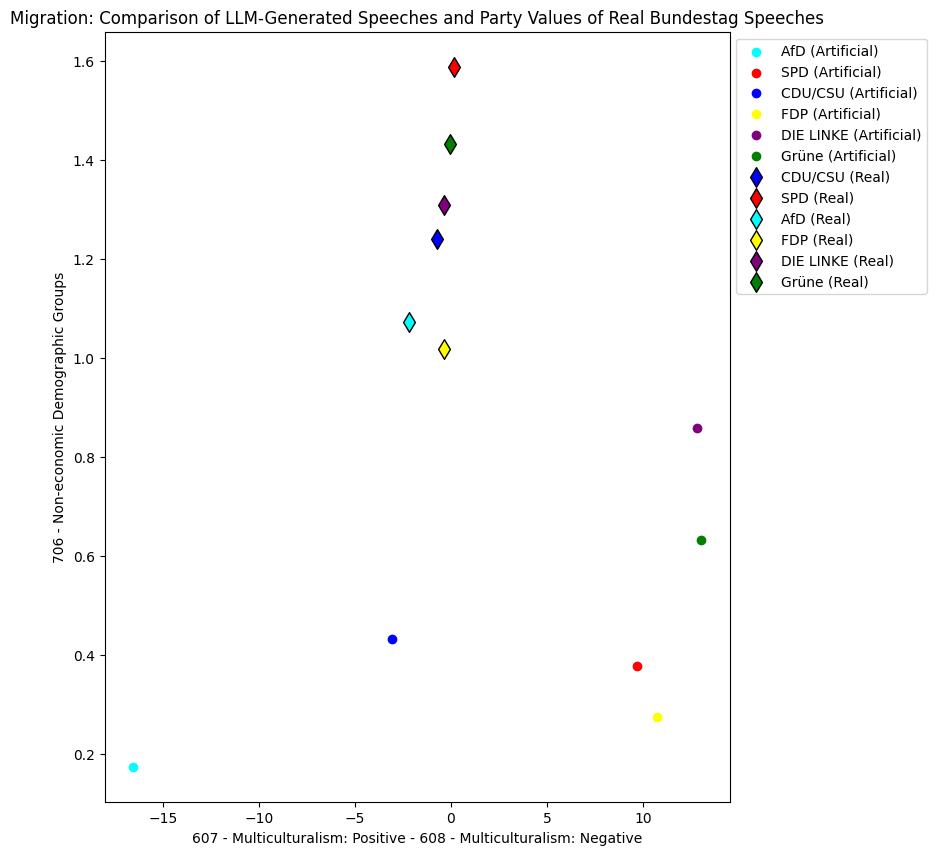

In [116]:
# Usage: 
dim_1a = '104 - Military: Positive'
dim_1b = '105 - Military: Negative'
dim_2a = '108 - European Community/Union: Positive'
dim_2b = '110 - European Community/Union: Negative'

topic_of_interest = 'Ukraine-Krieg'



plot_dimension_comparison(llm_speeches=llm_speeches_party, df_speeches=covid_speeches, 
                          topic_of_interest='Covid-19', 
                          dims_x = ['305 - Political Authority'],
                          dims_y=['201 - Freedom and Human Rights'])


plot_dimension_comparison(llm_speeches=llm_speeches_party, df_speeches=ukraine_war_speeches, 
                          topic_of_interest='Ukraine-Krieg', 
                          dims_x = ['104 - Military: Positive', '105 - Military: Negative'],
                          dims_y=['108 - European Community/Union: Positive', '110 - European Community/Union: Negative'])

plot_dimension_comparison(llm_speeches=llm_speeches_party, df_speeches=migration_speeches, 
                          topic_of_interest='Migration', 
                          dims_x = ['607 - Multiculturalism: Positive', '608 - Multiculturalism: Negative'],
                          dims_y=['706 - Non-economic Demographic Groups'])


In [106]:
covid_speeches.columns

Index(['id_x', 'session', 'electoral_term', 'date', 'document_url',
       'speech_content', 'politician_id', 'first_name', 'last_name',
       'faction_id', 'abbreviation', 'full_name', 'position_short',
       'position_long', 'speech_tokenized', 'tokenized_length',
       '504 - Welfare State Expansion', '503 - Equality: Positive',
       '701 - Labour Groups: Positive', '305 - Political Authority',
       '603 - Traditional Morality: Positive',
       '706 - Non-economic Demographic Groups',
       '303 - Governmental and Administrative Efficiency',
       '506 - Education Expansion', '411 - Technology and Infrastructure',
       '202 - Democracy', '604 - Traditional Morality: Negative',
       '601 - National Way of Life: Positive',
       '606 - Civic Mindedness: Positive',
       '501 - Environmental Protection: Positive', '403 - Market Regulation',
       '201 - Freedom and Human Rights',
       '108 - European Community/Union: Positive', '402 - Incentives',
       '401 - Free 

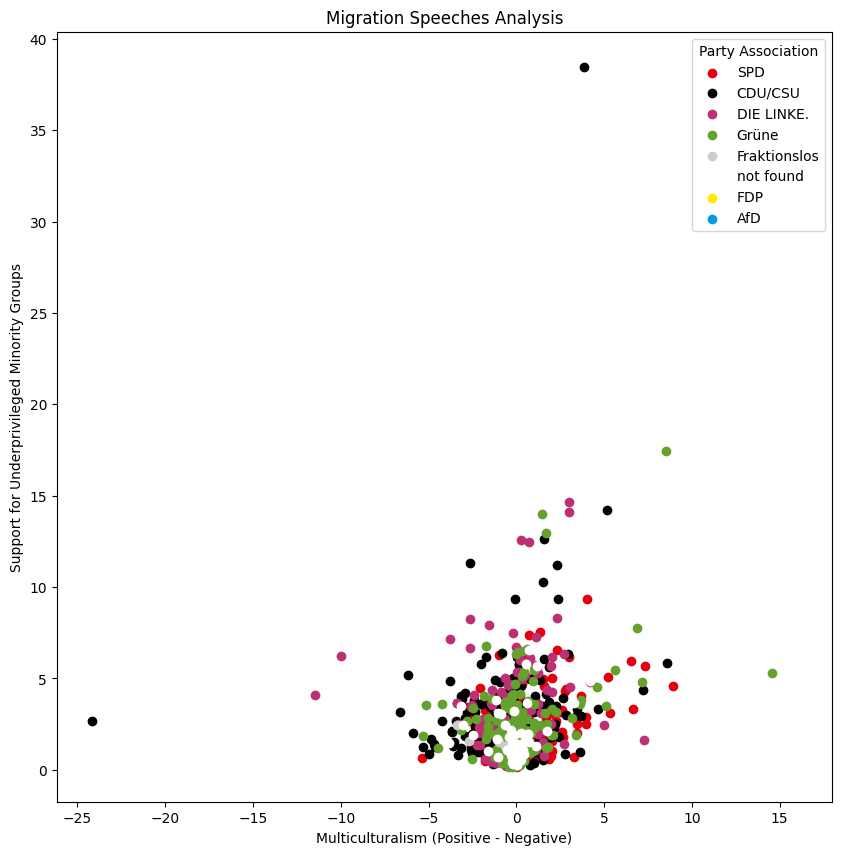

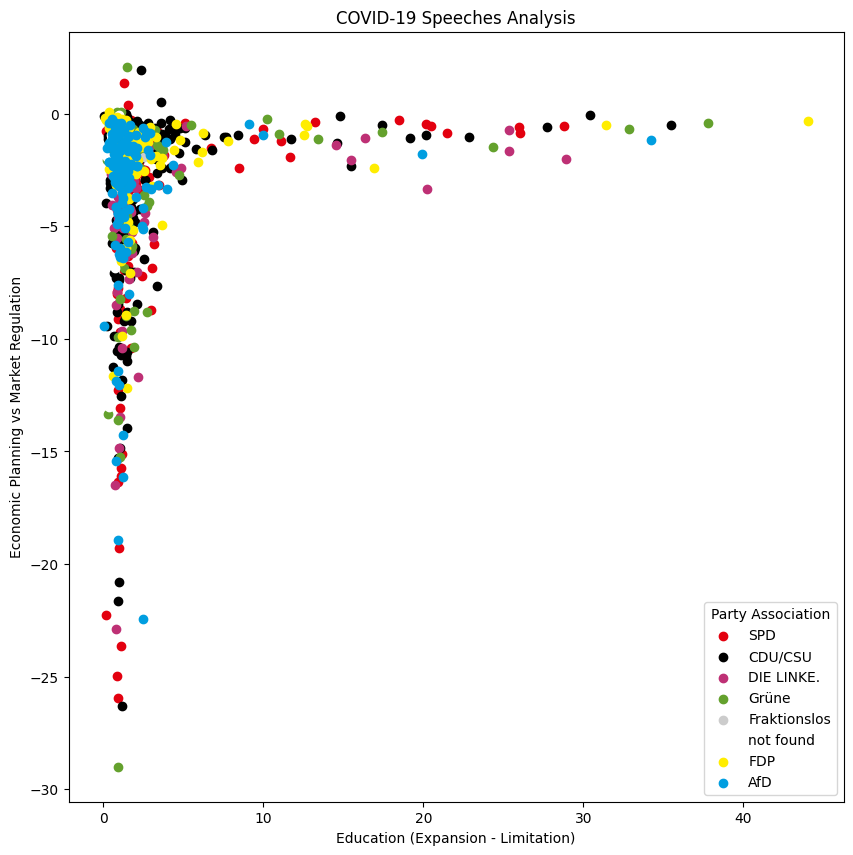

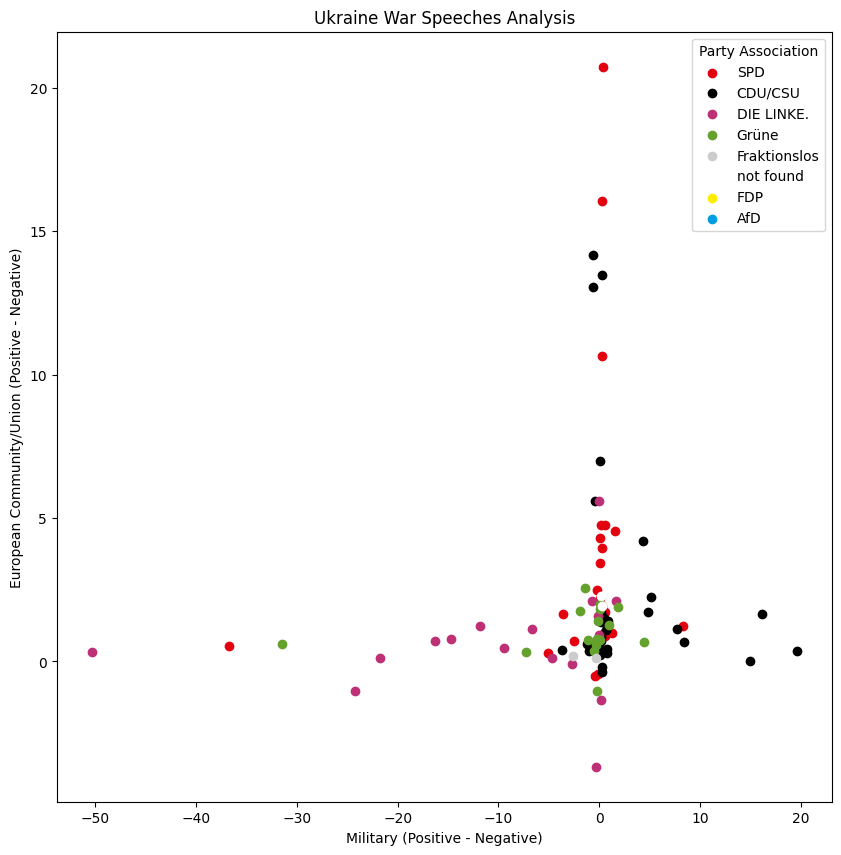

In [62]:
import matplotlib.pyplot as plt

# Define the color_map as given previously
# Assuming color_map is already defined

# Function to plot speeches analysis
def plot_speeches_analysis(df, x_columns, y_columns, x_label, y_label, title):
    plt.figure(figsize=(10, 10))
    for party, color in color_map.items():
        indices = [i for i, abbr in enumerate(df['abbreviation']) if abbr == party]
        x_values = df[x_columns[0]][indices] - df[x_columns[1]][indices] if len(x_columns) > 1 else df[x_columns[0]][indices]
        y_values = df[y_columns[0]][indices] - df[y_columns[1]][indices] if len(y_columns) > 1 else df[y_columns[0]][indices]
        plt.scatter(x_values, y_values, color=color, label=party)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(title="Party Association")
    plt.show()

# Plot for migration_speeches
plot_speeches_analysis(migration_speeches, 
                       ['607 - Multiculturalism: Positive', '608 - Multiculturalism: Negative'], 
                       ['705 - Underprivileged Minority Groups'], 
                       'Multiculturalism (Positive - Negative)', 
                       'Support for Underprivileged Minority Groups', 
                       'Migration Speeches Analysis')

# Plot for covid_speeches
plot_speeches_analysis(covid_speeches, 
                       ['506 - Education Expansion', '507 - Education Limitation'], 
                       ['404 - Economic Planning', '403 - Market Regulation'], 
                       'Education (Expansion - Limitation)', 
                       'Economic Planning vs Market Regulation', 
                       'COVID-19 Speeches Analysis')
plot_speeches_analysis(ukraine_war_speeches,
                       ['104 - Military: Positive', '105 - Military: Negative'],
                       ['108 - European Community/Union: Positive', '110 - European Community/Union: Negative'],
                       'Military (Positive - Negative)',
                       'European Community/Union (Positive - Negative)',
                       'Ukraine War Speeches Analysis')



In [57]:
# import os

# # Define the path where the new folder will be created
# folder_path = '/kaggle/working/outputs'

# # Check if the folder already exists
# if not os.path.exists(folder_path):
#     # If the folder does not exist, create it
#     os.makedirs(folder_path)
#     print(f"Folder '{folder_path}' created.")
# else:
#     print(f"Folder '{folder_path}' already exists.")

# ukraine_war_speeches.to_pickle('/kaggle/working/outputs/ukraine_war_speeches.pkl')
# migration_speeches.to_pickle('/kaggle/working/outputs/migration_speeches.pkl')
# covid_speeches.to_pickle('/kaggle/working/outputs/covid_speeches.pkl')


Folder '/kaggle/working/outputs' already exists.
